In [1]:
'''
Huggingface BERT Model: dccuchile/bert-base-spanish-wwm-uncased
https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

Necessary installations: Python, Pandas, Numpy, Sklearn, PyTorch, transformers, TrainingArguments, tensorflow, spacy, os, 
python -m spacy download es_core_news_sm
'''

'\nHuggingface BERT Model: dccuchile/bert-base-spanish-wwm-uncased\nhttps://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased\n'

In [58]:
import pandas as pd
import numpy as np
import sklearn 
from transformers import TrainingArguments
import os

In [59]:
from transformers import set_seed
set_seed(42)

In [60]:
df = pd.read_csv('data/icm_dataset.csv')
print(df.head(25))

                                                input  intent
0                      Quisiera comprar una camiseta.       1
1                     Me gustaría pedir una camiseta.       1
2                        Necesito una camiseta nueva.       1
3                     Quiero una camiseta de algodón.       1
4        Estoy buscando una camiseta en talla grande.       1
5           Deseo comprar una camiseta con estampado.       1
6            ¿Puedo pedir una camiseta en color azul?       1
7            Necesitaría una camiseta de manga corta.       1
8         Estoy interesado en una camiseta deportiva.       1
9            Quiero comprar una camiseta para correr.       1
10           Me gustaría adquirir una camiseta negra.       1
11                Quisiera una camiseta sin etiqueta.       1
12              Necesito una camiseta para un regalo.       1
13         Deseo pedir una camiseta en talla mediana.       1
14              ¿Podría tener una camiseta en oferta?       1
15      

In [61]:
# Parts of Speech (POS)
import spacy

# Carga modelo de Spanish NLP 
nlp = spacy.load("es_core_news_sm")

def get_pos_tags(text):
    # Process the text with spaCy
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]  # Extract each word and its POS tag 
    return pos_tags

# ejemplo
sentence = "¿Cómo puedo cambiar mi contraseña?"
pos_tags = get_pos_tags(sentence)
print(pos_tags)


[('¿', 'PUNCT'), ('Cómo', 'PRON'), ('puedo', 'AUX'), ('cambiar', 'VERB'), ('mi', 'DET'), ('contraseña', 'NOUN'), ('?', 'PUNCT')]


In [62]:
# Apply POS tagging to a column of df (no sé si mejora el rendimiento del modelo todavia, podemos studiarlo...)
df['pos_tags'] = df['input'].apply(get_pos_tags)

In [63]:
df.head()

,input,intent,pos_tags
0,Quisiera comprar una camiseta.,1,"[(Quisiera, VERB), (comprar, VERB), (una, DET)..."
1,Me gustaría pedir una camiseta.,1,"[(Me, PRON), (gustaría, VERB), (pedir, VERB), ..."
2,Necesito una camiseta nueva.,1,"[(Necesito, VERB), (una, DET), (camiseta, NOUN..."
3,Quiero una camiseta de algodón.,1,"[(Quiero, VERB), (una, DET), (camiseta, NOUN),..."
4,Estoy buscando una camiseta en talla grande.,1,"[(Estoy, AUX), (buscando, VERB), (una, DET), (..."


In [64]:
from sklearn.model_selection import train_test_split

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['input'], df['intent'], test_size=0.1)  # Reserving 10% for testing
train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels, test_size=0.2)  # Split remaining 90% into training and validation

In [65]:
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import joblib

tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Save the tokenizer
save_directory = "C:\\Users\\dusti\\Documents\\Silbo\\beto\\model_save"

# Save the tokenizer to directory
tokenizer.save_pretrained(save_directory)

# already split data into train_texts, val_texts, test_texts, & train_labels, val_labels, and test_labels

# Tokenize texts: for train, valuation and test
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)  

# Encodes labels: train, valuation and test
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)  

# Your existing code for fitting the LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Saving the fitted LabelEncoder to disk for later use 
label_encoder_path = './model_save/label_encoder.pkl' 
joblib.dump(label_encoder, label_encoder_path)

['./model_save/label_encoder.pkl']

In [66]:
'''
Creates instances of the IntentDataset for training, validation, and testing.
Way to "wrap" input data and labels for an intent classification task into a PyTorch format.
En fin:
Prepara los datos para el entrenamiento, la validación y el testeo en nuestro modelo de ML con PyTorch.
'''

import torch

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert all sets to PyTorch datasets 
train_dataset = IntentDataset(train_encodings, train_labels_encoded)
val_dataset = IntentDataset(val_encodings, val_labels_encoded)
test_dataset = IntentDataset(test_encodings, test_labels_encoded) 

In [69]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, SchedulerType

num_labels = len(set(train_labels_encoded))
model = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',                 # creates output directory for model and logs
    num_train_epochs=5,                     # number of training epochs: +1 for Fine-Tuning
    per_device_train_batch_size=16,         # batch size: Training
    per_device_eval_batch_size=32,         # batch size: Evaluation
    warmup_steps=500,                       # n warmup steps
    weight_decay=0.01,                      # strength of weight decay
    logging_steps=10,
    evaluation_strategy="epoch",            # evaluate each `logging_steps`
    learning_rate=5e-5,                     # initial learning rate
    lr_scheduler_type=SchedulerType.COSINE, # Linear works best in the end 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# Evaluate model
trainer.evaluate()
test_results = trainer.evaluate(test_dataset)
print(test_results)

# Define path where we want to save our model and training state
model_path = "C:\\Users\\dusti\\Documents\\Silbo\\beto\\model_save"

# Save model & training state
trainer.save_model(model_path)
trainer.state.save_to_json(os.path.join(model_path, "trainer_state.json"))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\dusti\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 1.134, 'grad_norm': 6.32993221282959, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.56}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0898706912994385, 'eval_runtime': 1.9348, 'eval_samples_per_second': 36.696, 'eval_steps_per_second': 1.551, 'epoch': 1.0}
{'loss': 1.0812, 'grad_norm': 7.1303534507751465, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.11}
{'loss': 1.0401, 'grad_norm': 6.685537815093994, 'learning_rate': 3e-06, 'epoch': 1.67}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.961395800113678, 'eval_runtime': 2.0603, 'eval_samples_per_second': 34.461, 'eval_steps_per_second': 1.456, 'epoch': 2.0}
{'loss': 0.9834, 'grad_norm': 5.941992282867432, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.22}
{'loss': 0.8983, 'grad_norm': 6.328485488891602, 'learning_rate': 5e-06, 'epoch': 2.78}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.7781420350074768, 'eval_runtime': 2.4321, 'eval_samples_per_second': 29.193, 'eval_steps_per_second': 1.233, 'epoch': 3.0}
{'loss': 0.789, 'grad_norm': 6.178040504455566, 'learning_rate': 6e-06, 'epoch': 3.33}
{'loss': 0.6528, 'grad_norm': 7.810218811035156, 'learning_rate': 7.000000000000001e-06, 'epoch': 3.89}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.5869789719581604, 'eval_runtime': 2.2796, 'eval_samples_per_second': 31.146, 'eval_steps_per_second': 1.316, 'epoch': 4.0}
{'loss': 0.5479, 'grad_norm': 7.404865264892578, 'learning_rate': 8.000000000000001e-06, 'epoch': 4.44}
{'loss': 0.4721, 'grad_norm': 9.507509231567383, 'learning_rate': 9e-06, 'epoch': 5.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.4573231637477875, 'eval_runtime': 2.7499, 'eval_samples_per_second': 25.819, 'eval_steps_per_second': 1.091, 'epoch': 5.0}
{'train_runtime': 226.2894, 'train_samples_per_second': 6.231, 'train_steps_per_second': 0.398, 'train_loss': 0.8443066702948676, 'epoch': 5.0}


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.32072073221206665, 'eval_runtime': 1.6182, 'eval_samples_per_second': 24.719, 'eval_steps_per_second': 1.236, 'epoch': 5.0}


In [70]:
# Metricas:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = test_labels_encoded  # True labels
predictions = trainer.predict(test_dataset).predictions.argmax(axis=1)  # Model predictions

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # Used 'weighted' for imbalanced classes but unnecessary here
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: 0.975
Precision: 0.9770833333333332
Recall: 0.975
F1 Score: 0.975


In [79]:
# Fine-tuning y sus Metricas: 
# La diferencia entre la primera y segunda columna es el aumento de 120 frases nuevas en el dataset
# Evaluation_Loss se basa en test dataset

cols = ['Epochs', 'Evaluation_Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Tiempo', 'LR_scheduler_type', 'Training_Batch_Size', 'Evaluation_Batch_Size']
df_metricas = pd.DataFrame(index=range(8), columns=cols)
df_metricas.loc[0] = [3, 0.98, 0.56, 0.532, 0.56, 0.537, 1.12, 'NaN', 16, 64]
df_metricas.loc[1] = [3, 0.97, 0.81, 0.829, 0.81, 0.817, 1.22, 'NaN', 16, 64]
df_metricas.loc[2] = [3, 0.825, 0.828, 0.825, 0.814, 0.69, 1.36, 'Cosine', 16, 32]
df_metricas.loc[3] = [3, 0.469, 0.9, 0.919, 0.9, 0.898, 2.37, 'Linear', 16, 64]
df_metricas.loc[4] = [3,  0.572, 0.9, 0.919, 0.9, 0.899, 3.13, 'Cosine', 16, 64]
df_metricas.loc[5] = [3, 0.541, 0.811, 0.822, 0.811, 0.797, 1.15, 'Linear', 36, 128]
df_metricas.loc[6] = [4, 0.91, 0.65, 0.67, 0.65, 0.65, 2.38, 'Cosine', 36, 128]
df_metricas.loc[7] = [4, 0.943, 0.625, 0.631, 0.625, 0.621, 2.33, 'Linear', 44, 128]
df_metricas.loc[8] = [5, 0.321, 0.975, 0.977, 0.975, 0.75, 3.46, 'Cosine', 16, 32]

df_metricas

,Epochs,Evaluation_Loss,Accuracy,Precision,Recall,F1,Tiempo,LR_scheduler_type,Training_Batch_Size,Evaluation_Batch_Size
0,3,0.98,0.56,0.532,0.56,0.537,1.12,NaN,16,64
1,3,0.97,0.81,0.829,0.81,0.817,1.22,NaN,16,64
2,3,0.825,0.828,0.825,0.814,0.69,1.36,Cosine,16,32
3,3,0.469,0.9,0.919,0.9,0.898,2.37,Linear,16,64
4,3,0.572,0.9,0.919,0.9,0.899,3.13,Cosine,16,64
5,3,0.541,0.811,0.822,0.811,0.797,1.15,Linear,36,128
6,4,0.91,0.65,0.67,0.65,0.65,2.38,Cosine,36,128
7,4,0.943,0.625,0.631,0.625,0.621,2.33,Linear,44,128
8,5,0.321,0.975,0.977,0.975,0.75,3.46,Cosine,16,32


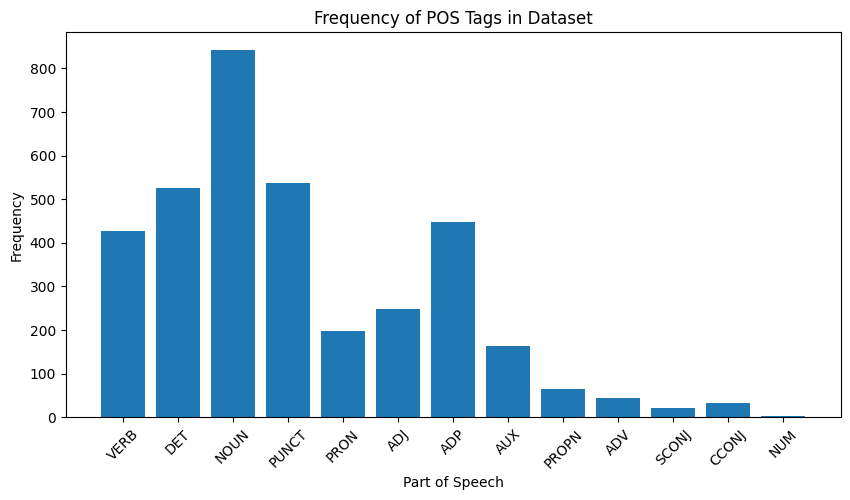

In [71]:
# Representacion visual de POS para que podamos ver las frecuencias:

from collections import Counter
import matplotlib.pyplot as plt

# df['pos_tags'] contains lists of (word, POS) tuples
pos_counts = Counter([pos for row in df['pos_tags'] for _, pos in row])

plt.figure(figsize=(10, 5))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.title('Frequency of POS Tags in Dataset')
plt.xticks(rotation=45)
plt.show()

In [80]:
# Función de Prediccion de intents del input (frase)

def predict_intent(frase):
    # Tokenize input 
    inputs = tokenizer(frase, padding=True, truncation=True, max_length=128, return_tensors="pt")   #pt = pytorch

    # Predict
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get predicted label ID
    predicted_label_id = logits.argmax().item()

    # Decode label ID back to label name, el [0] indica que usa el primer elemento de la columna intent, en nuestro caso: 1 
    predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
    return predicted_label

# Probar input para verificar intent, funciona bien con 3 pero no siempre con 1 y 2
frase = "quiero informacion sobre la empresa"
predicted_intent = predict_intent(frase)
print(f"Predicted intent: {predicted_intent}")

Predicted intent: 2
